# Project 1 


In [1]:
# Required libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from IPython.display import Image
import scipy.integrate
import random
from scipy.sparse.linalg import spsolve
import imageio.v2 as imageio

# Part 1
## Numerical experiments of Crank-Nicolson scheme

$u_t = \mu u_{xx} + f(u)$

$
\left(I - \frac{r}{2}D\right)U^{n+1} = \left(I + \frac{r}{2}D +akI+\frac{ark}{2}D + \frac{a^2k^2}{2}I\right)U^{n}$

In [25]:

def u(x, t, c, b):
    return np.exp(c*t)*np.sin(b*x)

def tridiag(n, a, b):
    return np.diag(b*np.ones(n-1), -1) + np.diag(a*np.ones(n), 0) + np.diag(b*np.ones(n-1), 1)


def modified_Crank_Nic(M, N, b, a, mu):

    h=1/M
    k=1/N
    r = mu * k / h**2
    c = -mu*b**2 + a

    x = np.linspace(0, 1, M+1)
    A = np.diag(np.ones(M-1)) - 0.5 * r * tridiag(M-1, -2, 1)
    F = np.diag(np.ones(M-1)) + 0.5*r * tridiag(M-1, -2, 1) + a*k*np.diag(np.ones(M-1)) + 0.5*a*k*r * tridiag(M-1, -2, 1)+ 0.5*a*k*a*k*np.diag(np.ones(M-1))

    U = np.zeros((N, M+1))
    Ui = np.zeros((N, M-1))

    U[0] = u(x, 0, c, b)
    Ui[0] = u(x[1:-1], 0, c, b)


    B = np.zeros(M-1)

    for i in range(1, N):
        B[0] = (r/2)*u(0, i*k, c, b) + ((r/2)+ (a*r*k/2))*u(0, (i-1)*k, c, b) 
        B[-1] = (r/2)*u(1, i*k, c, b) + ((r/2)+ (a*r*k/2))*u(1, (i-1)*k, c, b)
        Ui[i] = np.linalg.solve(A, (np.dot(F, Ui[i-1]) + B))
        U[i, 0] = u(0, i*k, c, b)
        U[i, -1] = u(1, i*k, c, b)
        U[i, 1:-1] = Ui[i]

    return U

def plot_u(M, N, b, a, mu):

    c =  -mu*b**2 + a

    h=1/M
    k=1/N
    U = modified_Crank_Nic(M, N, b, a, mu)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = np.arange(0, 1+h, h)
    t = np.arange(0, 1, k)
    X, T = np.meshgrid(x, t)
    ax.plot_surface(X, T, U, cmap='inferno')
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u')
    plt.title('Numerical approximation of u(x,t)')
    plt.show()


    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, T, u(X, T, c, b), cmap='inferno')
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u')
    plt.title('Exact solution of u(x,t)')
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(X, T, np.abs(u(X, T, c, b)-U), cmap='inferno')
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('|u(x,t)-U|')
    plt.title('Error ')
    plt.show()

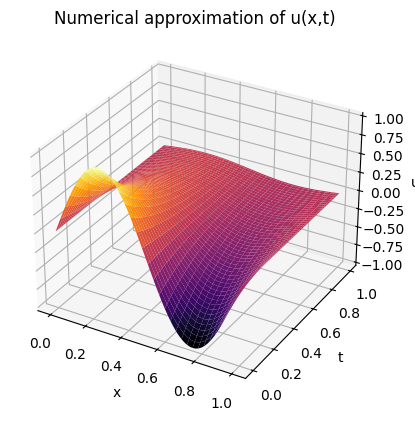

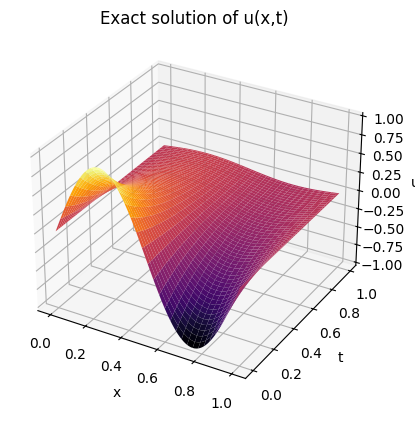

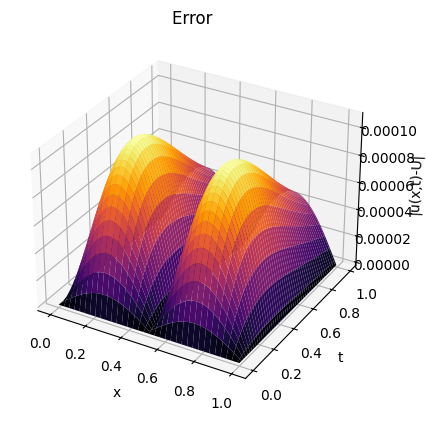

In [27]:
# r = mu * k/h^2

M= 100
N = 100

mu = 0.1
a = 1
b = 2*np.pi

plot_u(M, N, b, a, mu)


### Investigating the global error

In [28]:

def global_errf(U, M, N):
    h=1/M
    k=1/N
    x = np.arange(0, 1+h, h)
    t = np.arange(0, 1, k)
    X, T = np.meshgrid(x, t)
    # max error in each time step
    error = np.abs((u(X, T, c, b))-U)
    
    return np.max(error)

def global_errfk(U, M, N):
    h=1/M
    k=1/N
    x = np.arange(0, 1+h, h)
    t = np.arange(0, 1, k)
    X, T = np.meshgrid(x, t)
    # max error in each time step
    error = np.abs((u(X, T, c, b))-U)
    err = np.zeros(M)
    for i in range(M):
        err[i] = np.max(error[:,i])
    return err


cmap = plt.get_cmap('viridis')

c =  -mu*b**2 + a
M = 100
N = 100

mu = 0.001
a = 1
b = 2*np.pi


### Plotting the global error

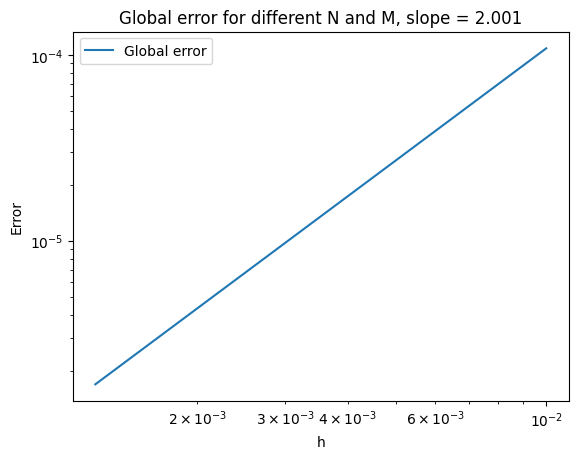

In [ ]:
N = 100
M = 100
mu = 0.1
a = 1
b = 2*np.pi
c =  -mu*b**2 + a

nb_points = 4
error = np.zeros(nb_points)
H= np.zeros(nb_points)

for i in range(0, nb_points):
    H[i]= 1/M
    U = modified_Crank_Nic(M, N, b, a, mu)
    error[i] = global_errf(U, M, N)
    N = N*2
    M = M*2


p = np.polyfit(np.log(H),np.log(error),1)

plt.loglog(H, error, label='Global error')
plt.legend()
plt.title(f'Global error for different N and M, slope = {p[0]:.3f}')
plt.xlabel('hhe')
plt.ylabel('Error')
plt.show()

# Part 2

## Application of the SIR model
We first create a simple SIR model using the model described in p1.pdf. The ODE is solved using the scipy library.

In [7]:
# Defining the model in form of ODE
def SIR_ODE(SIR, t, Beta, Gamma):
    """
    Input:
    SIR: list of 3 elements, S, I, R
    t: time
    Beta: transmission rate
    Gamma: recovery/death rate

    return:
    list of diffrentials of S, I and R
    """
    S, I, R = SIR
    dS =  - Beta*S*I
    dI = Beta*S*I - Gamma*I
    dR = Gamma*I
    return [dS, dI, dR]

t = np.arange(0, 20, 0.02)

N = 10000
I = 1/N
S = (N - 1)/N
R = 0

Beta0, Gamma0 = 3, 1

#Solving the ODE 
solution = scipy.integrate.odeint(SIR_ODE, y0 =[S, I, R], t=t, args=(Beta0, Gamma0) )


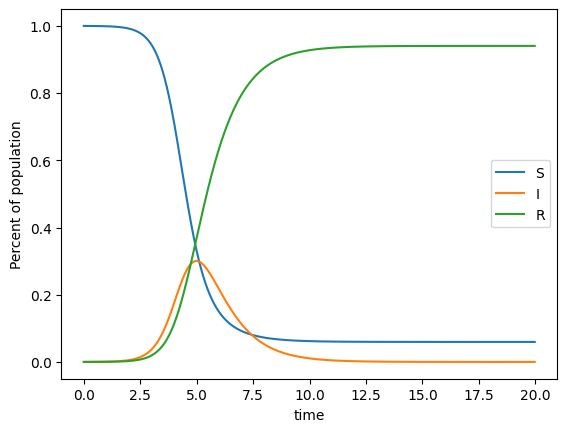

In [8]:

plt.plot(t, solution[:,0], label='S')
plt.plot(t, solution[:,1], label='I')
plt.plot(t, solution[:,2], label='R')
# plt.plot(t, solution[:,0] + solution[:,1] + solution[:,2], label='N')
plt.legend()
plt.xlabel('time')
plt.ylabel('Percent of population')
plt.show()

## Attempting multiple intitial values

Now that we have a working model, we generalize it into a function, then attempt different initial conditions 

In [9]:
def simulate(I0, Beta0, Gamma0, N= 10000):
    t = np.arange(0, 100, 1)

    I = I0/N
    S = (N - I0)/N
    R = 0

    solution = scipy.integrate.odeint(SIR_ODE, y0=[S, I, R], t=t, args=(Beta0, Gamma0) )
    plt.plot(t, solution[:,0], label='S')
    plt.plot(t, solution[:,1], label='I')
    plt.plot(t, solution[:,2], label='R')
    plt.plot(t, solution[:,0] + solution[:,1] + solution[:,2], label='N')
    plt.legend()
    plt.xlabel('time')
    
    plt.ylabel('Percent of population')
    plt.title('Beta = ' + str(Beta0) + ' Gamma = ' + str(Gamma0) + ' I_0 = ' + str(I0))
    plt.show()

We have commented out the code for testing multiple intial conditions, as the notebook would be too long, but feel free to have a look at the plots if interested

In [10]:

# for i in range(1, 100, 30):
#     for g in range(1, 10, 3):
#         for b in range(1, 10, 3):
#             simulate(i, b, g, N=100)

# Studying the spread of disease in space

In [50]:
mu_s = 0.01
mu_i = 0.01
Beta0 = 10
Gamma0 = 3



M=50
N=1000
k = 1/N
h = 1/M

def scheme_S(S, I, i, j, n, mu=mu_s, Beta=Beta0, k=k, h=h):
    if  k*mu/h**2>0.25:
        print( "stability condition not met")
    return (k*mu/h**2) *(S[i-1,j, n-1] + S[i+1,j,n-1] + S[i,j-1,n-1] + S[i,j+1,n-1]) + (1-k*Beta*I[i,j,n-1]- 4*k*mu/h**2) * S[i,j,n-1]


def scheme_I(S, I, i, j, n, mu=mu_i, Beta=Beta0, k=k, h=h, Gamma=Gamma0):
    if  k*mu/h**2>0.25:
        print( "stability condition not met")
    return I[i,j,n-1]*(k*Beta*S[i,j,n-1] - k*Gamma + 1 - 4*k*mu/h**2) + (k*mu/h**2)*(I[i-1,j,n-1] + I[i+1,j,n-1] + I[i,j-1,n-1] + I[i,j+1,n-1])


S = np.ones((M, M, N))
I = np.zeros((M, M, N))

#Removing the boundary points
S[0,:,:] = 1
S[-1,:,:] = 1 
S[:,0,:] = 1
S[:,-1,:] = 1

#Removing the boundary points
I[0,:,:] = 0
I[-1,:,:] = 0
I[:,0,:] = 0
I[:,-1,:] = 0

# Adding a small number of infected people to the system
I[20:25,10:15,0] = 0.1
S = S - I



for n in range(1,N):
    for i in range(1,M-1):
        for j in range(1,M-1):

            S[i,j,n] = scheme_S(S, I, i,j,n)#(k*mu_s/h**2) *(S[i-1,j, n-1] + S[i+1,j,n-1] + S[i,j-1,n-1] + S[i,j+1,n-1]) + (1-k*Beta0*I[i,j,n-1]- 4*k*mu_s/h**2) * S[i,j,n-1] 
            I[i,j,n] = scheme_I(S, I, i,j,n)#I[i,j,n-1]*(k*Beta0*S[i,j,n-1] - k*Gamma0 + 1 - 4*k*mu_i/h**2) + (k*mu_i/h**2)*(I[i-1,j,n-1] + I[i+1,j,n-1] + I[i,j-1,n-1] + I[i,j+1,n-1])

R = 1 - S - I




### Making the initial and final state plots for the report

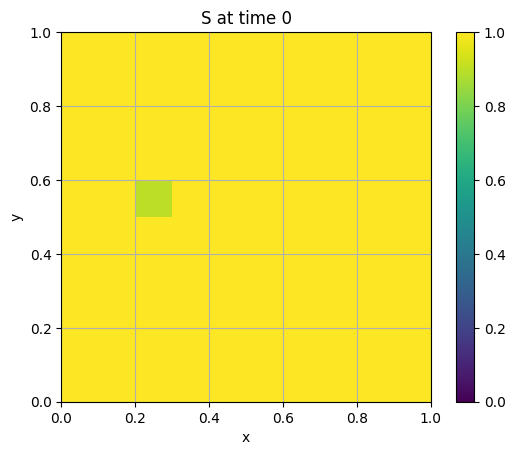

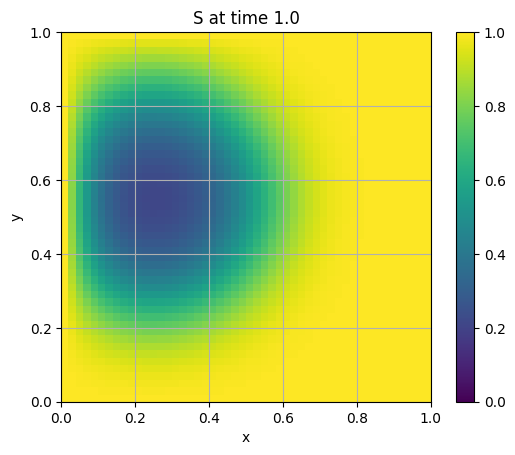

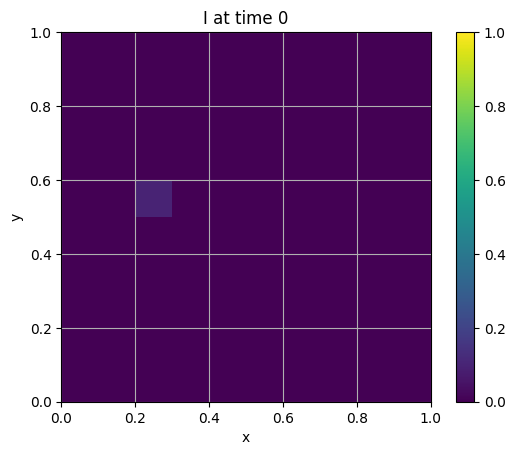

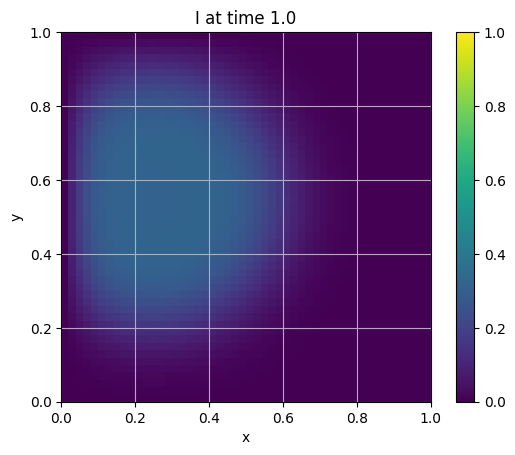

In [53]:
plt.imshow(S[:,:,0], vmin=0, vmax=1, extent=[0, 1, 0, 1])
plt.title(f'S at time {0}')
plt.colorbar()
plt.ylabel('y')
plt.xlabel('x')
plt.grid()
plt.show()

plt.imshow(S[:,:,-1], vmin=0, vmax=1, extent=[0, 1, 0, 1])
plt.title(f'S at time {N/N}')
plt.colorbar()
plt.ylabel('y')
plt.xlabel('x')
plt.grid()
plt.show()

plt.imshow(I[:,:,0], vmin=0, vmax=1, extent=[0, 1, 0, 1])
plt.title(f'I at time {0}')
plt.colorbar()
plt.ylabel('y')
plt.xlabel('x')
plt.grid()
plt.show()

plt.imshow(I[:,:,-1], vmin=0, vmax=1, extent=[0, 1, 0, 1])
plt.title(f'I at time {N/N}')
plt.colorbar()
plt.ylabel('y')
plt.xlabel('x')
plt.grid()
plt.show()


We have again removed some plots for the sake of brievety

In [14]:
# for i in range(0, N, round(N/10)):
#     plt.imshow(S[:,:,i], vmin=0, vmax=1)
#     plt.title(f'S at time {i}')
#     plt.colorbar()
#     plt.grid()
#     plt.show()
    
    
#     plt.imshow(I[:,:,i], vmin=0, vmax=1)
#     plt.title(f'I at time {i}')
#     plt.colorbar()
#     plt.grid()
#     plt.show()

## Saving the plots as gif's to better display them

This part is quite computing intensive so avoid running them too much many times

In [51]:
images = []

for i in range(0, N, 50):
    plt.imshow(S[:,:,i], vmin=0, vmax=1, extent=[0, 1, 0, 1])
    plt.title(f'Susceptible people at time {i/N}')
    plt.colorbar()
    plt.grid()
    plt.savefig('S.png')
    images.append(imageio.imread('S.png'))
    plt.close()
imageio.mimsave('S.gif', images)

images = []

for i in range(0, N, 50):
    plt.imshow(I[:,:,i], vmin=0, vmax=1, extent=[0, 1, 0, 1])
    plt.title(f'Infected people at time {i/N}')
    plt.colorbar()
    plt.grid()
    plt.savefig('I.png')
    images.append(imageio.imread('I.png'))
    plt.close()

imageio.mimsave('I.gif', images)

images = []
for i in range(0, N, 50):
    plt.imshow(R[:,:,i], vmin=0, vmax=1, extent=[0, 1, 0, 1])
    plt.title(f'Removed people at time {i/N}')
    plt.colorbar()
    plt.grid()
    plt.savefig('R.png')
    images.append(imageio.imread('R.png'))
    plt.close()

imageio.mimsave('R.gif', images)



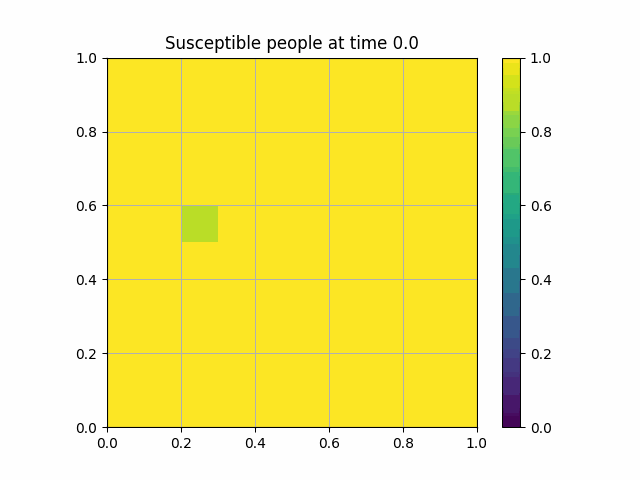

In [52]:
Image(filename="S.gif")

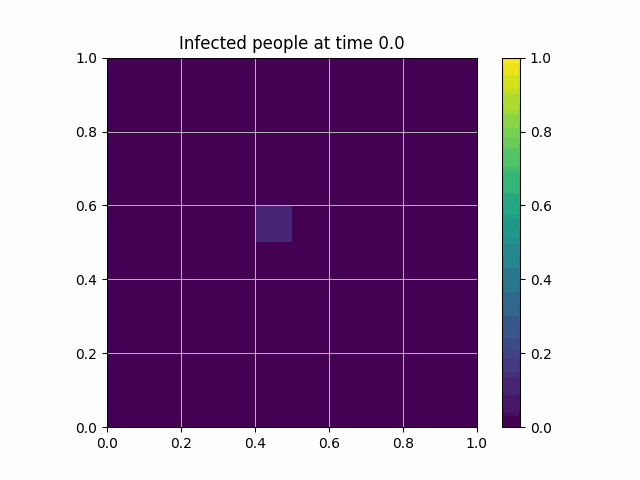

In [20]:
Image(filename="I.gif")

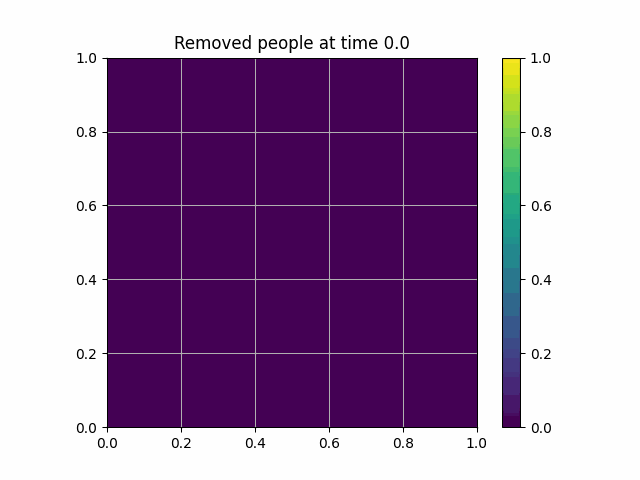

In [21]:
Image(filename="R.gif")


In [23]:
#Simplifying the process into a function
def simulate_infections(S, I, mu_s, mu_i, Beta0, Gamma0, M, N, k, h):
    for n in range(1,N):
        for i in range(1,M-1):
            for j in range(1,M-1):
                S[i,j,n] = scheme_S(S, I, i, j, n, mu_s, Beta0, k, h)
                I[i,j,n] = scheme_I(S, I, i, j, n, mu_i, Beta0, k, h, Gamma0)

    R = 1 - S - I
    return S, I, R


def plot_infections(S, I, T):
    for t in range(0, T, round(T/5)):
        plt.imshow(S[:,:,t], vmin=0, vmax=1, extent=[0, 1, 0, 1])
        plt.title(f'S at time {t}')
        plt.colorbar()
        plt.grid()
        plt.show()

        plt.imshow(I[:,:,t], vmin=0, vmax=1, extent=[0, 1, 0, 1])
        plt.title(f'I at time {t}')
        plt.colorbar()
        plt.grid()
        plt.show()
        


## Using an infected boundary 

We didnt end up using this, but it was interesting to look at what happens if we use an infected boundary. 

In [ ]:

S = np.ones((M, M, N))
I = np.zeros((M, M, N))

#Removing the boundary points
S[0,:,:] = 0
S[-1,:,:] = 0
S[:,0,:] = 0
S[:,-1,:] = 0

#Infecting the boundary points
I[0,:,:] = 1
I[-1,:,:] = 1
I[:,0,:] = 1
I[:,-1,:] = 1

I[20:25,10:15,0] = 0.1
S = S - I


S, I, R = simulate_infections(S, I, mu_s, mu_i, Beta0, Gamma0, M, N, k, h)
# plot_infections(S, I, N)


## Using random initial spread

This wasnt included in the report, but we included it here cause it produced some interesting results. We initiate some infected people at random spots in the domain. 

In [30]:
mu_s = 0.01
mu_i = 0.001
Beta0 = 3
Gamma0 = 1

M=50
N=500
k = 1/N
h = 1/M

#Random intial infection
S = np.random.randint(9,11, (M,M,N))/10
I = 1 - S

#Removing the boundary points
S[0,:,:] = 0
S[-1,:,:] = 0
S[:,0,:] = 0
S[:,-1,:] = 0

#Removing the boundary points
I[0,:,:] = 0
I[-1,:,:] = 0
I[:,0,:] = 0
I[:,-1,:] = 0

S, I, R = simulate_infections(S, I, mu_s, mu_i, Beta0, Gamma0, M, N, k, h)
# plot_infections(S, I, N)


In [31]:
steps = 50
images = []

for i in range(0, N, steps):
    plt.imshow(S[:,:,i], vmin=0, vmax=1, extent=[0, 1, 0, 1])
    plt.title(f'Susceptible people at time {i/N}')
    plt.colorbar()
    plt.grid()
    plt.savefig('S.png')
    images.append(imageio.imread('S.png'))
    plt.close()
imageio.mimsave('S.gif', images)

images = []

for i in range(0, N, steps):
    plt.imshow(I[:,:,i], vmin=0, vmax=1, extent=[0, 1, 0, 1])
    plt.title(f'Infected people at time {i/N}')
    plt.colorbar()
    plt.grid()
    plt.savefig('I.png')
    images.append(imageio.imread('I.png'))
    plt.close()

imageio.mimsave('I.gif', images)




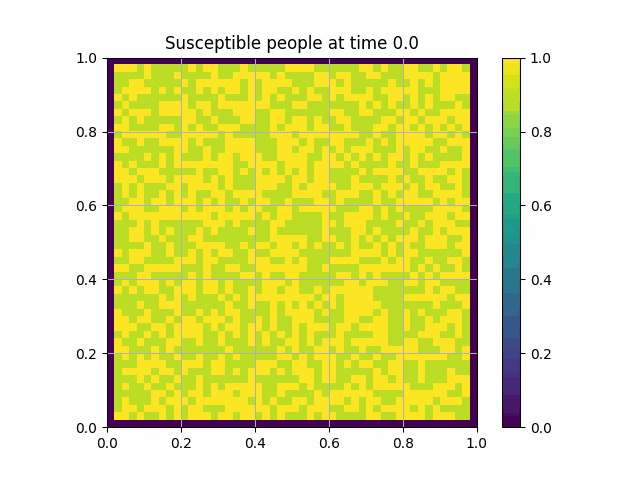

In [32]:
Image(filename="S.gif")

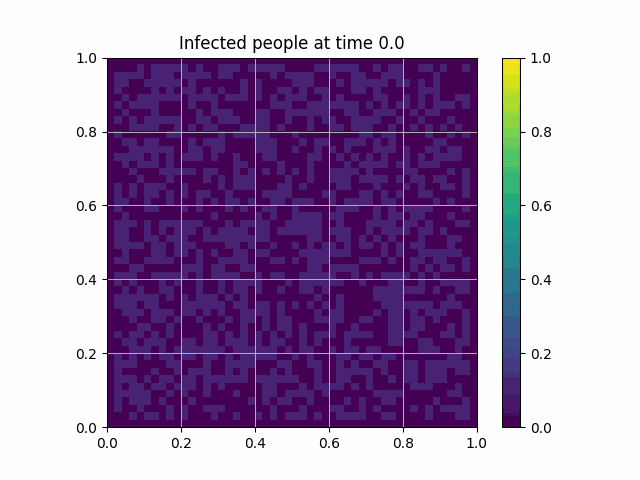

In [34]:
Image(filename="I.gif")

In [ ]:
# for i in range(0, N, round(N/10)):
#     plt.imshow(R[:,:,i], vmin=0, vmax=1)
#     plt.title(f'R at time {i}')
#     plt.colorbar()
#     plt.grid()
#     plt.show()

# Simulating people with one area not washing hands

Here we simulate a part of the population having a higher $\beta$ than other parts of the domain. We modify the scheme such that for $20>i>10$ and $40>j>30$,  $\beta$ is chosen to be a value $\beta_{dh}$ so that we can simulate a higher infectivety in that area. We interperete this as people not washing their hands, and thus they spread more germs

In [41]:
# Define the sceme for the SIR model
def simulate_dirtyhands(S, I, mu_s, mu_i, Beta0, Beta_dh, Gamma0, M, N, k, h):
    for n in range(1,N):
        for i in range(1,M-1): 
            for j in range(1,M-1):
                if i<20 and j < 40 and i > 10 and j > 30:
                    S[i,j,n] = scheme_S(S, I, i, j, n, mu_s, Beta_dh, k, h)
                    I[i,j,n] = scheme_I(S, I, i, j, n, mu_i, Beta_dh, k, h, Gamma0)
                else:
                    S[i,j,n] = scheme_S(S, I, i, j, n, mu_s, Beta0, k, h)
                    I[i,j,n] = scheme_I(S, I, i, j, n, mu_i, Beta0, k, h, Gamma0)

    R = 1 - S - I
    return S, I, R


In [42]:
N=1000
M=50
k= 1/N
h= 1/M


S = np.ones((M, M, N))
I = np.zeros((M, M, N))



#Setting the boundary to be healthy
S[0,:,:] = 1
S[-1,:,:] = 1
S[:,0,:] = 1
S[:,-1,:] = 1

#Removing the boundary points
I[0,:,:] = 0
I[-1,:,:] = 0
I[:,0,:] = 0
I[:,-1,:] = 0

I[20:25,10:15,0] = 0.1
S = S - I

S, I, R = simulate_dirtyhands(S, I, 0.05, 0.01, 10, 60, 3, M, N, k, h)



In [43]:
steps = 25
images = []

for i in range(0, N, steps):
    plt.imshow(S[:,:,i], vmin=0, vmax=1, extent=[0, 1, 0, 1])
    plt.title(f'Susceptible people at time {i/N}')
    plt.colorbar()
    plt.grid()
    plt.savefig('S.png')
    images.append(imageio.imread('S.png'))
    plt.close()
imageio.mimsave('S_dh.gif', images)

images = []

for i in range(0, N, steps):
    plt.imshow(I[:,:,i], vmin=0, vmax=1, extent=[0, 1, 0, 1])
    plt.title(f'Infected people at time {i/N}')
    plt.colorbar()
    plt.grid()
    plt.savefig('I.png')
    images.append(imageio.imread('I.png'))
    plt.close()

imageio.mimsave('I_dh.gif', images)

images = []

for i in range(0, N, steps):
    plt.imshow(R[:,:,i], vmin=0, vmax=1, extent=[0, 1, 0, 1])
    plt.title(f'Removed people at time {i/N}')
    plt.colorbar()
    plt.grid()
    plt.savefig('R.png')
    images.append(imageio.imread('R.png'))
    plt.close()

imageio.mimsave('R_dh.gif', images)

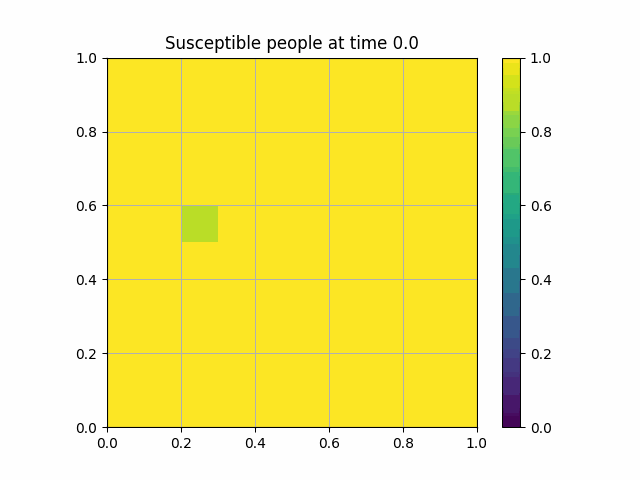

In [44]:

Image(filename="S_dh.gif")


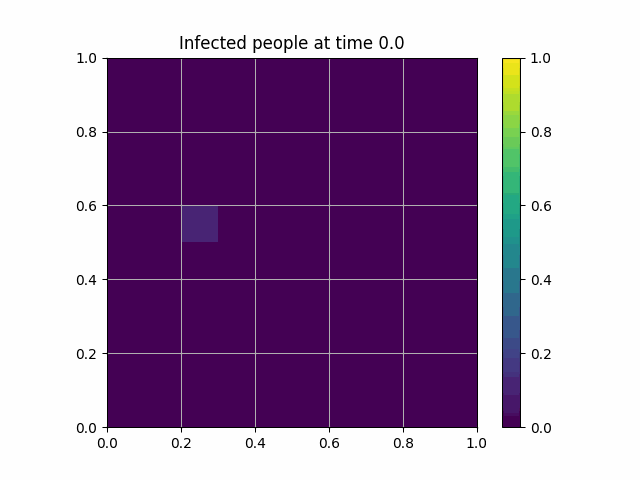

In [49]:
Image(filename="I_dh.gif")

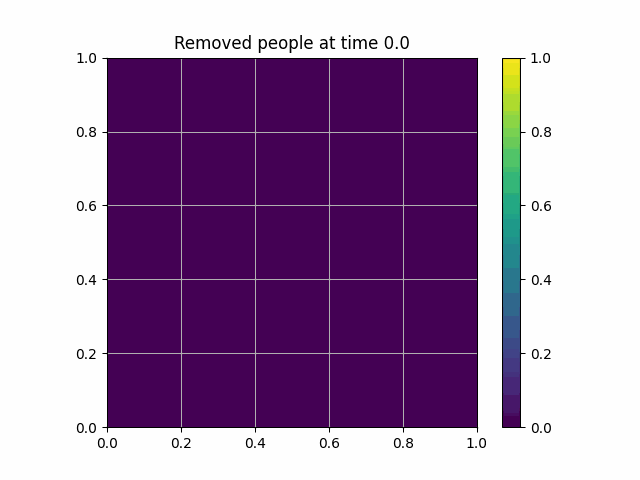

In [48]:
Image(filename="R_dh.gif")

### Making the plots for the report

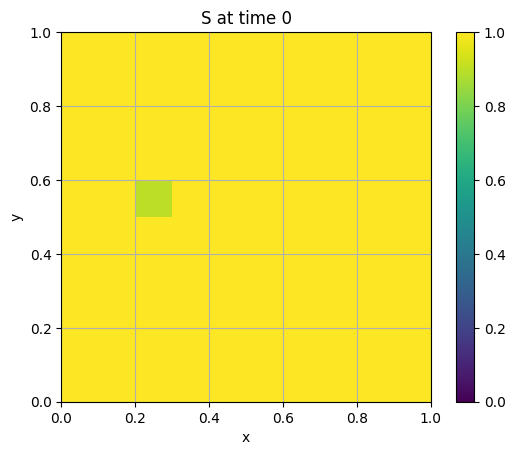

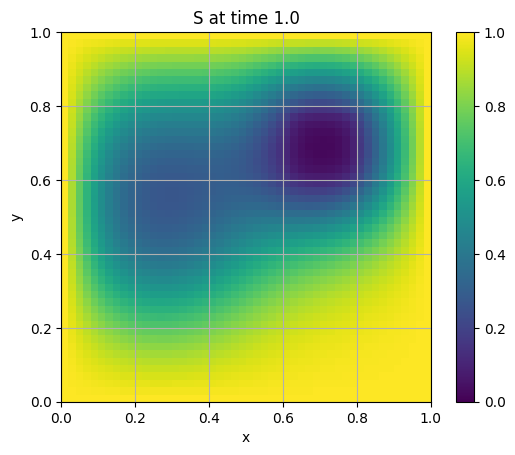

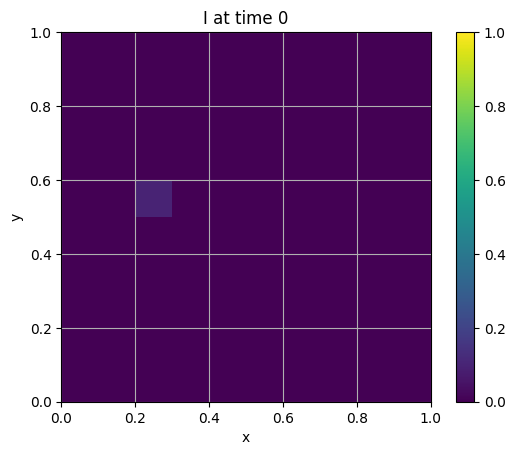

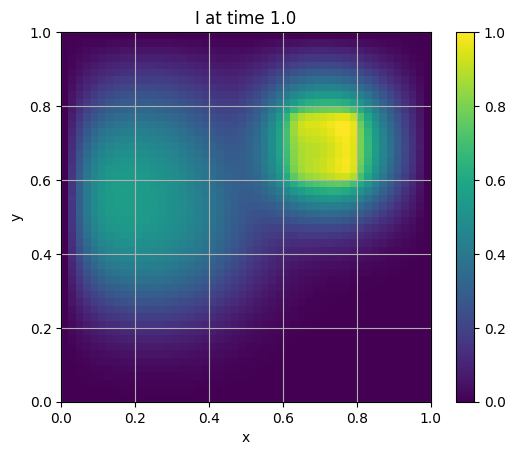

In [47]:
plt.imshow(S[:,:,0], vmin=0, vmax=1, extent=[0, 1, 0, 1])
plt.title(f'S at time {0}')
plt.colorbar()
plt.ylabel('y')
plt.xlabel('x')
plt.grid()
plt.show()

plt.imshow(S[:,:,-1], vmin=0, vmax=1, extent=[0, 1, 0, 1])
plt.title(f'S at time {N/N}')
plt.colorbar()
plt.ylabel('y')
plt.xlabel('x')
plt.grid()
plt.show()


plt.imshow(I[:,:,0], vmin=0, vmax=1, extent=[0, 1, 0, 1])
plt.title(f'I at time {0}')
plt.colorbar()
plt.ylabel('y')
plt.xlabel('x')
plt.grid()
plt.show()

plt.imshow(I[:,:,-1], vmin=0, vmax=1, extent=[0, 1, 0, 1])
plt.title(f'I at time {N/N}')
plt.colorbar()
plt.ylabel('y')
plt.xlabel('x')
plt.grid()
plt.show()
